# CEIA - Visión por computadora 2

Integrantes del equipo:

* a1604 | Federico Arias Suárez | f_ariassuarez@hotmail.com
* a1618 | Myrna Lorena,Degano | myrna.l.degano@gmail.com
* a1620 | Gustavo Julián Rivas | gus.j.rivas@gmail.com


In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-sb1dyfs3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-sb1dyfs3
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

In [3]:
import os, shutil, random, yaml, json, math, torch, argparse, glob, gdown, zipfile, logging

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns

from tqdm import tqdm
from roboflow import Roboflow
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from PIL import Image, ImageDraw, ImageFont
from collections import Counter, defaultdict
from pathlib import Path
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix


import detectron2

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, build_detection_test_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.data.transforms import *
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils import registry
from detectron2.structures import BoxMode
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.data import transforms as T
from detectron2.data.detection_utils import read_image


## Conjunto de datos

* <u>Tipo de problema a resolver</u>: Detección de objetos.  
<br>
* <u>Objetivo</u>: Detectar focos de incendio.  
<br>
* <u>Motivación</u>: La Amazonía se está quemando a un ritmo alarmante, afectando el clima, la biodiversidad y el calentamiento global.
Detectar incendios de manera temprana podría marcar la diferencia para evitar daños mayores.

* <u>Créditos</u>:  

 - **title**: Wildfire_Full Dataset
 - **type**: Open Source Dataset
 - **author**: MyWorkspace
 - **URL**: https://universe.roboflow.com/myworkspace-iraqv/wildfire_full
 - **published**: Roboflow Universe
 - **publisher**: Roboflow
 - **year**: 2024
 - **month**: oct

In [4]:
# Download desde Roboflow
rf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")
project = rf.workspace("myworkspace-iraqv").project("wildfire_full")
version = project.version(1)

loading Roboflow workspace...
loading Roboflow project...


In [5]:
format = 'coco'
dataset_name = 'Wildfire_Full-1'
root_path = '/content/'
download_path = root_path + dataset_name

In [6]:
# Download del conjunto de datos publicado en formato COCO
dataset = version.download(format)


Extracting Dataset Version Zip to Wildfire_Full-1 in coco:: 100%|██████████| 896/896 [00:00<00:00, 1164.56it/s]


In [7]:
files_in_directory = os.listdir(download_path)

new_dataset_name = dataset_name + '_' + format

dataset_path_coco = root_path + new_dataset_name

!mv "{download_path}" "{dataset_path_coco}"

In [8]:
# Corregir definiciones de clases (sólo 2 -> Fire/Smoke)
for step in ['train', 'valid', 'test']:

  print(f'\n{step}:')
  # Cargar el archivo JSON de anotaciones
  annotations_file = f'{dataset_path_coco}/{step}/_annotations.coco.json'

  with open(annotations_file, 'r') as f:
      data = json.load(f)

  print(data['categories'])

  # Eliminar la categoría con id 0
  data['categories'] = [category for category in data['categories'] if category['id'] != 0]

  # Reindexar las categorías para que empiecen desde 1
  category_id_map = {category['id']: idx + 1 for idx, category in enumerate(data['categories'])}
  for category in data['categories']:
      category['id'] = category_id_map[category['id']]

  # Verificar las categorías después de la modificación
  print("Categorias después de eliminación y reindexación:")
  print(data['categories'])

  # Guardar el archivo JSON corregido
  with open(annotations_file, 'w') as f:
    json.dump(data, f)



train:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]

valid:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]

test:
[{'id': 0, 'name': 'Fire', 'supercategory': 'none'}, {'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]
Categorias después de eliminación y reindexación:
[{'id': 1, 'name': 'Fire', 'supercategory': 'Fire'}, {'id': 2, 'name': 'Smoke', 'supercategory': 'Fire'}]


In [9]:
classes_list = []

for category in data['categories']:

  classes_list.append(category['name'])

print(classes_list)


['Fire', 'Smoke']


## Resultados Retinanet

In [10]:
# Instancia de Configuración del modelo
cfg = get_cfg()

In [11]:
# Crear el directorio de salida donde se guardarán los modelos entrenados y otros archivos relacionados.
cfg.OUTPUT_DIR = "detectron2-output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [12]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [13]:
register_coco_instances("coco_dataset_train", {}, dataset_path_coco + "/train/_annotations.coco.json", dataset_path_coco + "/train")
register_coco_instances("coco_dataset_valid", {}, dataset_path_coco + "/valid/_annotations.coco.json", dataset_path_coco + "/valid")
register_coco_instances("coco_dataset_test", {}, dataset_path_coco + "/test/_annotations.coco.json", dataset_path_coco + "/test")

In [14]:
dataset_train_metadata = MetadataCatalog.get("coco_dataset_train")
dataset_train_dicts = DatasetCatalog.get("coco_dataset_train")

[12/07 02:24:50 d2.data.datasets.coco]: Loaded 622 images in COCO format from /content/Wildfire_Full-1_coco/train/_annotations.coco.json


In [15]:
model = "COCO-Detection/retinanet_R_50_FPN_1x.yaml"

# Cargar la configuración preentrenada desde el modelo en el modelo_zoo de Detectron2
cfg.merge_from_file(model_zoo.get_config_file(model))

In [16]:
cfg.DATASETS.TRAIN = ("coco_dataset_train", )
cfg.DATASETS.TEST = ("coco_dataset_valid", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
cfg.MODEL.RETINANET.NUM_CLASSES = 2
cfg.SOLVER.IMS_PER_BATCH = 4
n_epochs = 50
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = (len(dataset_train_dicts)//cfg.SOLVER.IMS_PER_BATCH)*n_epochs
cfg.TENSORBOARD = True
cfg.TEST.EVAL_PERIOD = 500

In [17]:
if torch.cuda.is_available():
    cfg.MODEL.DEVICE = "cuda"  # Usar GPU si está disponible
else:
    cfg.MODEL.DEVICE = "cpu"   # Usar CPU si no hay GPU disponible

cfg.MODEL.DEVICE

'cuda'

In [18]:
# Descargar los resultados previamente entrenados
file_id = '1Toey-PailC7mv4EBP0ZqH2v_mCv5pnbk'
url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo ZIP al entorno de ejecución
gdown.download(url, 'models.zip', quiet=False)

# Descomprimir el archivo ZIP en el entorno de ejecución
with zipfile.ZipFile('models.zip', 'r') as zip_ref:
    zip_ref.extractall('./')


Downloading...
From (original): https://drive.google.com/uc?id=1Toey-PailC7mv4EBP0ZqH2v_mCv5pnbk
From (redirected): https://drive.google.com/uc?id=1Toey-PailC7mv4EBP0ZqH2v_mCv5pnbk&confirm=t&uuid=b8c311b3-2e8e-40b4-96fc-492ef2609d6f
To: /content/models.zip
100%|██████████| 810M/810M [00:10<00:00, 80.4MB/s]


In [19]:
results_dir = './models/E3/'

cfg.MODEL.WEIGHTS = os.path.join(results_dir, "model_final.pth")
cfg.DATASETS.TEST = ("coco_dataset_test", )

cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("coco_dataset_test").set(thing_classes=["Fire", "Smoke"])
test_dataset_dicts = DatasetCatalog.get("coco_dataset_test")


[12/07 02:25:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/E3/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[12/07 02:25:13 d2.data.datasets.coco]: Loaded 89 images in COCO format from /content/Wildfire_Full-1_coco/test/_annotations.coco.json


### Metricas de entrenamiento

Obtenemos el archivo con el registro de las métricas evaluadas durante el entrenamiento del modelo:

In [20]:
decoder = json.JSONDecoder()

metrics_train = []
metrics_valid = []

with open(results_dir + 'metrics.json', 'r') as file:
    file_content = file.read()

    while file_content:
        obj, index = decoder.raw_decode(file_content)

        if 'bbox/AP' in obj:
          metrics_valid.append(obj)
        else:
          metrics_train.append(obj)

        file_content = file_content[index:].lstrip()

In [21]:
# Métricas de entrenamiento
iterations = [metric['iteration'] for metric in metrics_train]

loss_box_reg = [metric['loss_box_reg'] for metric in metrics_train]
loss_cls = [metric['loss_cls'] for metric in metrics_train]
total_loss = [metric['total_loss'] for metric in metrics_train]

* **loss_cls**: Pérdida de clasificación, que mide qué tan bien el modelo predice las clases de los objetos (por ejemplo, si la predicción de "Fuego" es correcta o no).

* **loss_box_reg**: Pérdida de regresión de la caja, que mide qué tan bien el modelo predice las coordenadas de la caja delimitadora.

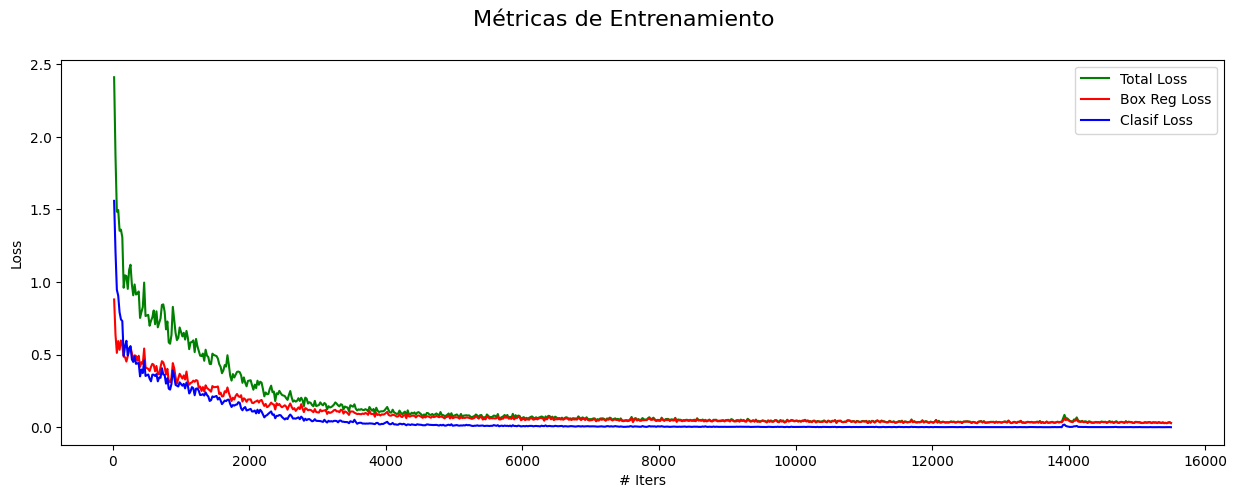

In [22]:
# Crear los subgráficos
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('Métricas de Entrenamiento', fontsize=16)

axes.plot(iterations, total_loss, color='green', label='Total Loss')
axes.plot(iterations, loss_box_reg, color='red', label='Box Reg Loss')
axes.plot(iterations, loss_cls, color='blue', label='Clasif Loss')
axes.set_xlabel('# Iters')
axes.set_ylabel('Loss')
plt.legend()
plt.show()

Las curvas de las funciones de pérdida durante el entrenamiento, muestran el comportamiento esperado.  

* Descenso: Al inicio del entrenamiento, el valor es alto, ya que el modelo no sabe clasificar correctamente los objetos.

* Mejora progresiva: A medida que el modelo avanza, el valor comienza a disminuir, lo que indica que el modelo está aprendiendo a clasificar correctamente las cajas detectadas en las categorías apropiadas.

* Estabilización: la pérdida se estabilizar luego de varias iteraciones cuando el modelo ha aprendido lo suficiente.


In [23]:
# Extraer las iteraciones y las métricas
iterations = [metric['iteration'] for metric in metrics_valid]

AP = [metric['bbox/AP'] for metric in metrics_valid]
AP_Fire = [metric['bbox/AP-Fire'] for metric in metrics_valid]
AP_Smoke = [metric['bbox/AP-Smoke'] for metric in metrics_valid]

AP50 = [metric['bbox/AP50'] for metric in metrics_valid]
AP75 = [metric['bbox/AP75'] for metric in metrics_valid]

APl = [metric['bbox/APl'] for metric in metrics_valid]
APm = [metric['bbox/APm'] for metric in metrics_valid]
APs = [metric['bbox/APs'] for metric in metrics_valid]

**AP (Average Precision)**
Es una métrica global que resume el rendimiento del modelo en términos de precisión y recall para diferentes umbrales de IoU (Intersection over Union).  

Mide cuán bien el modelo es capaz de clasificar y localizar objetos correctamente. En general, un mayor valor de AP indica que el modelo tiene un buen desempeño en detectar y clasificar los objetos.

El cálculo de AP implica:
* Obtener una curva de precisión-recall (precisión frente a recall) para diferentes umbrales de confianza (score de la predicción).
* El AP es el área bajo esta curva, que es un valor promedio que resume el desempeño del modelo.

**AP-Fire / AP-Smoke**  
Mide el desempeño del modelo específicamente para esa clase de objetos (Fire / Smoke).

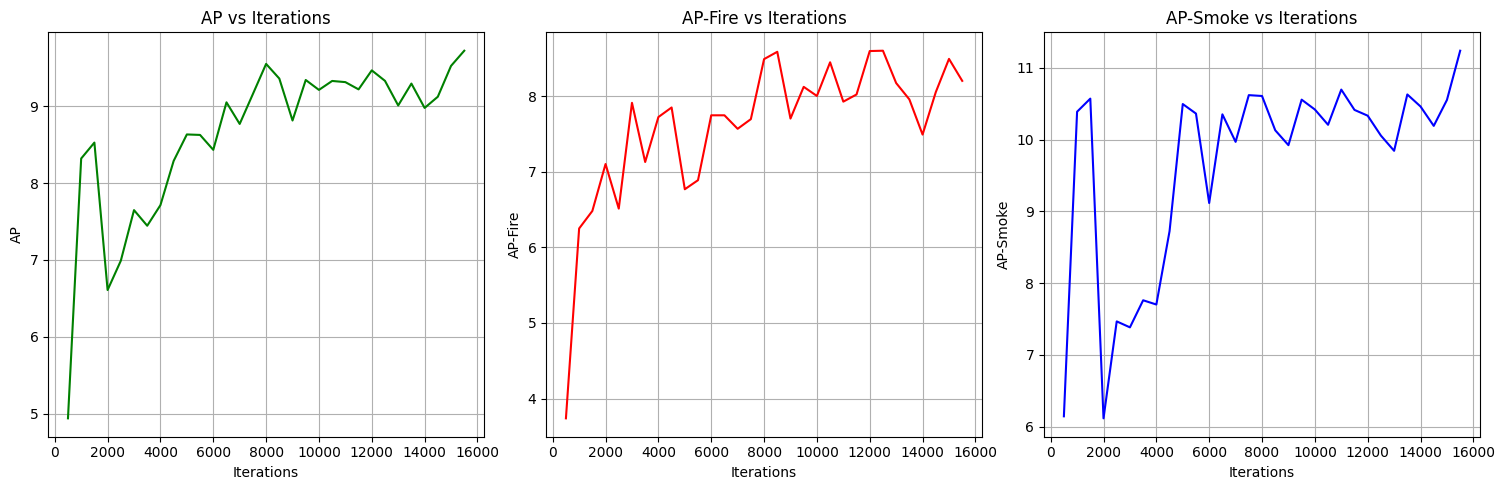

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Graficar cada métrica en su respectivo subgráfico
ax[0].plot(iterations, AP, label='AP', color='green')
ax[0].set_title('AP vs Iterations')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('AP')
ax[0].grid(True)

ax[1].plot(iterations, AP_Fire, label='AP-Fire', color='red')
ax[1].set_title('AP-Fire vs Iterations')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('AP-Fire')
ax[1].grid(True)

ax[2].plot(iterations, AP_Smoke, label='AP-Smoke', color='blue')
ax[2].set_title('AP-Smoke vs Iterations')
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('AP-Smoke')
ax[2].grid(True)

# Ajustar el layout para que no se solapen los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

**AP50 (Average Precision at IoU threshold = 0.50)**  
Es la precisión promedio (AP) medida específicamente cuando se utiliza un umbral de IoU = 0.50 para definir si una predicción es correcta.  

Aquí, una predicción se considera correcta si el IoU entre la caja predicha y la caja verdadera es mayor o igual a 0.50. Este valor refleja el desempeño del modelo cuando acepta un solapamiento moderado entre las predicciones y las anotaciones verdaderas.  

AP50 es útil cuando se quiere evaluar el modelo bajo condiciones relativamente relajadas, donde un 50% de solapamiento es suficiente para que una predicción se considere correcta.

<br>

**AP75 (Average Precision at IoU threshold = 0.75)**  
Es similar al AP50, pero se mide utilizando un umbral de IoU = 0.75.  
Esta métrica evalúa cuán preciso es el modelo cuando se exige un mayor solapamiento entre las predicciones y las cajas verdaderas, es decir, una predicción se considera correcta solo si el IoU es mayor o igual a 0.75.  

AP75 es más estricto que AP50 y refleja el rendimiento del modelo cuando se espera una mayor precisión en las predicciones.

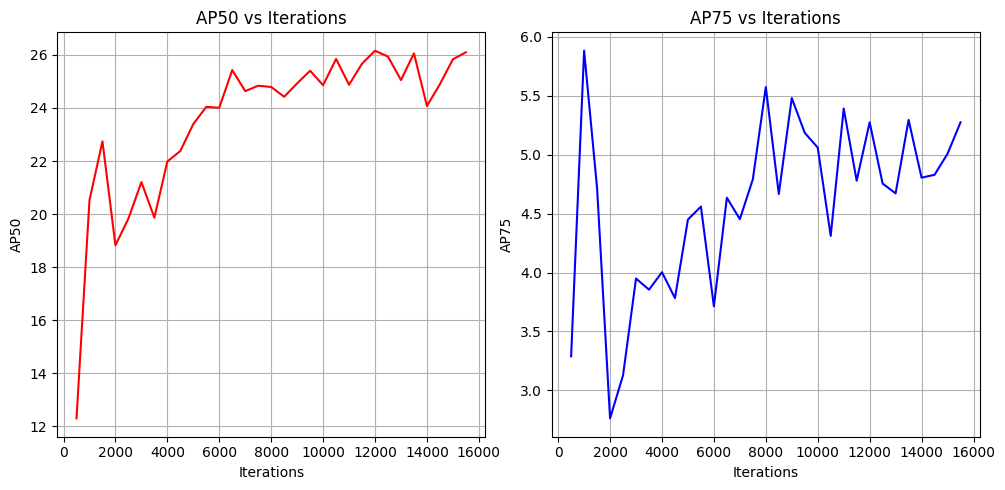

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Graficar cada métrica en su respectivo subgráfico
ax[0].plot(iterations, AP50, label='AP50', color='red')
ax[0].set_title('AP50 vs Iterations')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('AP50')
ax[0].grid(True)

ax[1].plot(iterations, AP75, label='AP75', color='blue')
ax[1].set_title('AP75 vs Iterations')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('AP75')
ax[1].grid(True)

# Ajustar el layout para que no se solapen los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

**APs (Average Precision for small objects)**  
El APs es una métrica similar al AP, pero específicamente para objetos pequeños.

Mide el rendimiento del modelo al detectar objetos de pequeño tamaño en las imágenes. Para los modelos de detección de objetos, "pequeños" generalmente se refiere a aquellos objetos cuyo área es inferior a un cierto umbral en píxeles.

Esta métrica es útil para evaluar cómo el modelo maneja objetos pequeños, que son más difíciles de detectar debido a su tamaño y visibilidad limitada en las imágenes.

De igual forma, **APm (Average Precision for medium objects)** / **APl (Average Precision for large objects)** para objetos de tamaño mediano / grande respectivamente.

<br>

 - Small (APs): Área de la caja delimitadora ≤ 32 x 32 píxeles
 - Medium (APm): Área de la caja delimitadora entre 32 x 32 y 96 x 96 píxeles
 - Large (APl): Área de la caja delimitadora > 96 x 96 píxeles

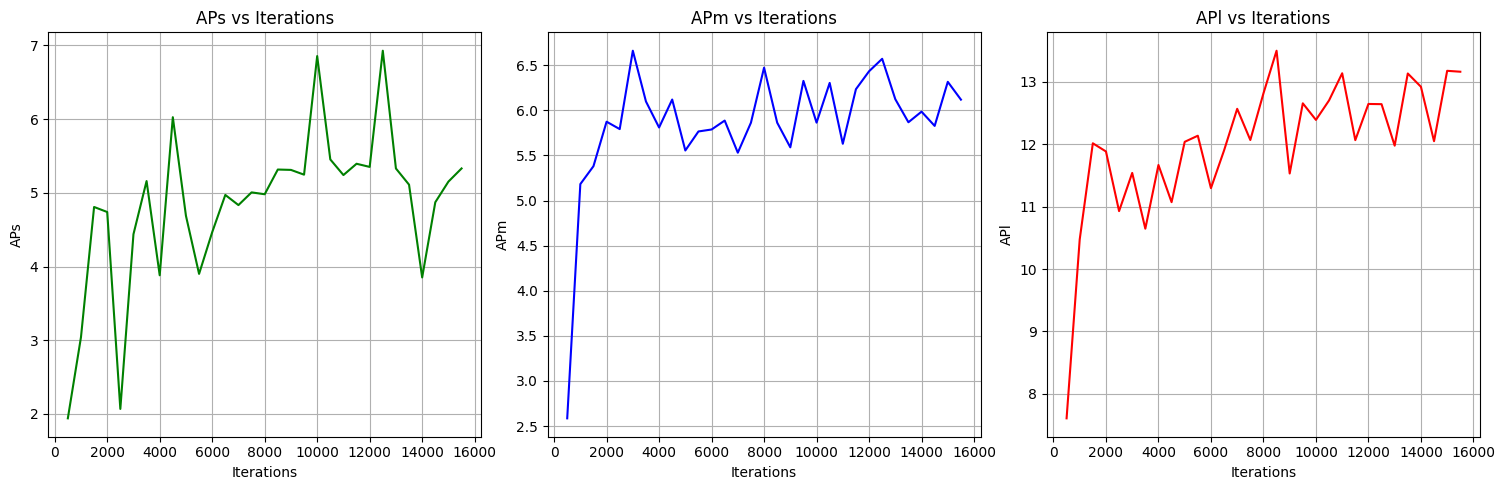

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Graficar cada métrica en su respectivo subgráfico
ax[0].plot(iterations, APs, label='APs', color='green')
ax[0].set_title('APs vs Iterations')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('APs')
ax[0].grid(True)

ax[1].plot(iterations, APm, label='APm', color='blue')
ax[1].set_title('APm vs Iterations')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('APm')
ax[1].grid(True)

ax[2].plot(iterations, APl, label='APl', color='red')
ax[2].set_title('APl vs Iterations')
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('APl')
ax[2].grid(True)

# Ajustar el layout para que no se solapen los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

In [27]:
metrics_df = metrics_valid[-1]

df = pd.DataFrame({
    'Métrica': metrics_df.keys(),
    'Valor alcanzado': metrics_df.values()
})

display(df.style.hide(axis='index'))

Métrica,Valor alcanzado
bbox/AP,9.719613
bbox/AP-Fire,8.201862
bbox/AP-Smoke,11.237365
bbox/AP50,26.097792
bbox/AP75,5.275323
bbox/APl,13.164211
bbox/APm,6.118696
bbox/APs,5.331396
iteration,15500.000000


Las métricas no son buenas, si bien algunas predicciones son acertadas, se observan varios falsos negativos y falsos positivos que hacen que la precisión global sea más pobre.  

<br><br>

* Falsos positivos (FP): Son los casos en los que el modelo predice una clase que no es la correcta.  

* Falsos negativos (FN): Son los casos en los que el modelo no detecta una clase que sí está presente.  

* Verdaderos positivos (TP): Son los casos en los que el modelo predice correctamente una clase.  

* Verdaderos negativos (TN): Son los casos en los que el modelo predice correctamente que no hay ninguna clase.



### Métricas sobre el set de pruebas

In [28]:
# Configurar el evaluador COCO
evaluator_test = COCOEvaluator("coco_dataset_test", cfg, False, output_dir=cfg.OUTPUT_DIR)

test_loader =  build_detection_test_loader(cfg,  "coco_dataset_test")

test_metrics = inference_on_dataset(predictor.model, test_loader, evaluator_test)


WARNING [12/07 02:25:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/07 02:25:17 d2.data.datasets.coco]: Loaded 89 images in COCO format from /content/Wildfire_Full-1_coco/test/_annotations.coco.json
[12/07 02:25:17 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    Fire    | 118          |   Smoke    | 178          |
|            |              |            |              |
|   total    | 296          |            |              |
[12/07 02:25:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/07 02:25:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/07 02:25:17 d2.data.co

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[12/07 02:25:20 d2.evaluation.evaluator]: Inference done 11/89. Dataloading: 0.0015 s/iter. Inference: 0.0658 s/iter. Eval: 0.0003 s/iter. Total: 0.0675 s/iter. ETA=0:00:05
[12/07 02:25:25 d2.evaluation.evaluator]: Inference done 86/89. Dataloading: 0.0018 s/iter. Inference: 0.0653 s/iter. Eval: 0.0003 s/iter. Total: 0.0674 s/iter. ETA=0:00:00
[12/07 02:25:25 d2.evaluation.evaluator]: Total inference time: 0:00:05.691319 (0.067754 s / iter per device, on 1 devices)
[12/07 02:25:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.065273 s / iter per device, on 1 devices)
[12/07 02:25:25 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/07 02:25:25 d2.evaluation.coco_evaluation]: Saving results to detectron2-output/coco_instances_results.json
[12/07 02:25:25 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[12/07 02:25:25 d2.eva

In [29]:
print("\Test Metrics (mAP (bbox)):\n")

for key, value in test_metrics.items():
    if isinstance(value, dict):

        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value:.4f}")
    else:
        print(f"{key}: {value:.4f}")

\Test Metrics (mAP (bbox)):

  AP: 11.5948
  AP50: 29.5253
  AP75: 6.9386
  APs: 4.2065
  APm: 9.1745
  APl: 12.7295
  AP-Fire: 6.4622
  AP-Smoke: 16.7275


### Ejemplo de predicciones

In [30]:
# Obtener la lista de imágenes .jpg en el directorio de test
image_paths = glob.glob(dataset_path_coco + '/test/*jpg')

len(image_paths)

89

In [31]:
n_sample = 30
sample_images = random.sample(image_paths, n_sample)

In [32]:
for i, imageName in enumerate(sample_images):

    # Leer la imagen con OpenCV
    im = cv.imread(imageName)
    im_rgb = im[:, :, ::-1]  # Convertir de BGR a RGB

    # Buscar la anotación correspondiente para esta imagen (basado en el nombre)
    gt_annotation = None
    for dataset_dict in test_dataset_dicts:
        if dataset_dict["file_name"] == imageName:
            gt_annotation = dataset_dict
            break

    if gt_annotation is None:
        print("No se encontraron anotaciones para esta imagen.")
        continue

    # Visualizador para las anotaciones
    gt_v = Visualizer(im_rgb, metadata=test_metadata)
    gt_out = gt_v.draw_dataset_dict(gt_annotation)

    # Realizar la predicción del modelo
    outputs = predictor(im)  # Realizar la predicción

    print(f'\n\n{i + 1})')

    # Extraer las predicciones de boxes, scores y clases
    boxes = outputs["instances"].pred_boxes
    scores = outputs["instances"].scores
    classes = outputs["instances"].pred_classes

    # Obtener la cantidad de detecciones
    num_detections = len(scores)  # La cantidad de instancias detectadas

    # Convertir las clases y puntuaciones a formato de lista para visualización
    classes_np = classes.cpu().numpy()  # Mover a CPU y convertir a NumPy array
    scores_np = scores.cpu().numpy()    # Mover a CPU y convertir a NumPy array

    # Visualizar las imágenes
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # Subplot con 1 fila y 2 columnas

    # Mostrar la imagen original con sus anotaciones
    ax = axes[0]
    ax.imshow(gt_out.get_image())  # Mostrar imagen con las anotaciones de ground truth
    ax.set_title("Imagen Original con Anotaciones")
    ax.axis("off")  # Ocultar los ejes

    # Visualizar la imagen con las predicciones
    v = Visualizer(im_rgb, metadata=test_metadata, scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Mostrar la imagen con las predicciones
    ax = axes[1]
    ax.imshow(out.get_image())  # Mostrar imagen con las predicciones
    ax.set_title("Imagen con Predicciones del Modelo")
    ax.axis("off")  # Ocultar los ejes

    # Mostrar ambas imágenes lado a lado
    plt.show()


Output hidden; open in https://colab.research.google.com to view.